In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

from Triangle_BBH.Utils import ParamDict2ParamArr, ParamArr2ParamDict
from scipy.optimize import differential_evolution

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Load data

In [ ]:
h5filename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOBv4opt_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [ ]:
h5paramfilename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOB4opt_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file:
    parameters = read_dict_from_h5(h5file["/"])
parameters.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [ ]:
channel_names = list(data_dict["XYZ"].keys())
data_channels = []
for ch in channel_names: 
    data_channels.append(data_dict["XYZ"][ch])
data_channels = np.array(data_channels)
data_time = data_dict["time"]
dt = data_time[1] - data_time[0]

data_time.shape, data_channels.shape 

((6294349,), (3, 6294349))

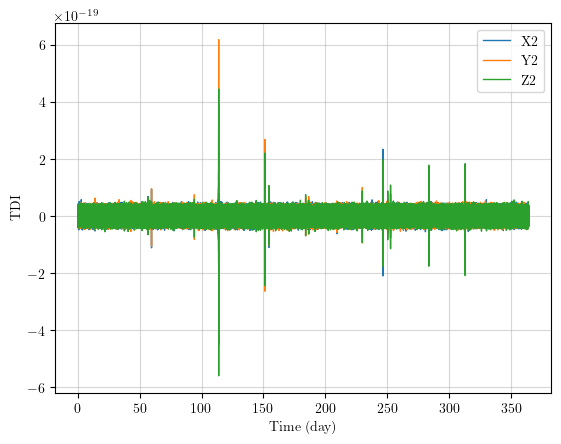

In [ ]:
for ich, ch in enumerate(channel_names): 
    plt.plot(data_time/DAY, data_channels[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")
plt.grid(linestyle="-", which="major", alpha=0.5)
plt.grid(linestyle=":", which="minor", alpha=0.4)

## Slice data 

In [ ]:
T_analyze = 5 * DAY 
T_pad_before = 5 * DAY 
T_pad_end = 2 * DAY 

In [ ]:
# prior of tc: start_time -> end_time 
# data time: start_pad_time -> end_pad_time 
start_time = 55. * DAY 
start_pad_time = start_time - T_pad_before
end_time = start_time + T_analyze
end_pad_time = end_time + T_pad_end 

# slice data 
idx_slice = np.where((data_time>=start_pad_time)&(data_time<=end_pad_time))[0]
time_slice = data_time[idx_slice]
data_slice = data_channels[:, idx_slice]

time_slice.shape, data_slice.shape, time_slice[0]/DAY, time_slice[-1]/DAY 

((207361,), (3, 207361), 55.0, 67.0)

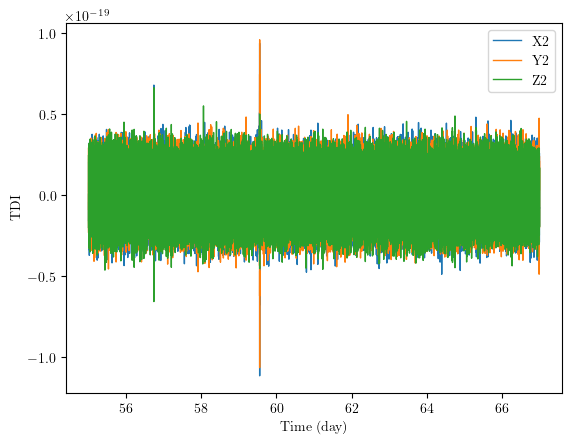

In [ ]:
for ich, ch in enumerate(channel_names): 
    plt.plot(time_slice/DAY, data_slice[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

## Load truths for comparison 

In [ ]:
# load source parameters for comparison 
mbhb_idx = np.where((parameters["coalescence_time"]*DAY >= start_time)&(parameters["coalescence_time"]*DAY <= end_time))[0]
mbhb_parameters = dict()
for k, v in parameters.items():
    mbhb_parameters[k] = v[mbhb_idx]
mbhb_parameters

{'chirp_mass': array([], dtype=float64),
 'coalescence_phase': array([], dtype=float64),
 'coalescence_time': array([], dtype=float64),
 'inclination': array([], dtype=float64),
 'latitude': array([], dtype=float64),
 'longitude': array([], dtype=float64),
 'luminosity_distance': array([], dtype=float64),
 'mass_ratio': array([], dtype=float64),
 'psi': array([], dtype=float64),
 'spin_1z': array([], dtype=float64),
 'spin_2z': array([], dtype=float64)}

## Search 

In [ ]:
searched_source_count = 0 
searched_params = [] 
searched_signal_td = []
searched_signal_fd = []
run_flag = True 

while run_flag: 
    # load data 
    if searched_source_count == 0: 
        data_td = data_slice[0].copy()
    else: 
        data_td = data_slice[0] - np.sum(np.array(searched_signal_td), axis=0)
    
    # set time 
    data_time = time_slice.copy()
    dt = data_time[1] - data_time[0]

    # fourier transform of data 
    win_args = dict(window_type="tukey", window_args_dict=dict(alpha=0.05))
    data_frequency, data_fd = FFT_window(data_td, fsample=1./dt, **win_args)
    df = data_frequency[1] - data_frequency[0]

    # remove null frequencies 
    mask = np.ones_like(data_frequency, dtype=bool)
    for i in range(1, 41):
        mask_idx = np.where(np.abs(data_frequency - i * 0.025) < 3e-4 * i)[0]
        mask[mask_idx] = False 
    data_frequency = data_frequency[mask]
    data_fd = data_fd[mask]
    # print("frequency-domain data shape:", data_fd.shape)

    # calculate PSD at given arm length 
    orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
    arms = dict()
    for key in MOSA_labels: 
        arms[key] = float(orbit.LTTfunctions()[key](np.mean(data_time)))
    # assumming noises are known 
    PSDfunc = TDIPSDs()
    PSDdata = PSDfunc.PSD_X2_unequal(data_frequency, arms)

    # signal model 
    mbhb_waveform_generator = MBHB_Injection(approx_method="SEOBNRv4_opt", buffer=True)
    mbhb_response_generator = FastMichelsonTDIResponse(
        orbit=orbit,
        tcb_times=data_time.copy(), 
        use_gpu=False, 
        drop_points=int(1000./dt), 
        interp_method="linear",
        complex_waveform_interp_order=3,
    )

    # snr as a function of parameters 
    def rho_dl(params): 
        """ SNR with luminosity distance marginalized, params is 10-d """
        params_full = np.zeros(11, dtype=np.float64)
        params_full[:6] = params[:6]
        params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
        try: 
            template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
        except (RuntimeError, ValueError) as e: 
            # print("error:", e)
            # print("error parameters:", params_full)
            template_td = np.zeros_like(data_td)
        _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
        template_fd = template_fd[mask]
        d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
        h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
        return d_h_inner / np.sqrt(h_h_inner)

    def cost_function(params):
        """ costfunction = - SNR, params is 10-d """
        return -rho_dl(params)

    # recover dl and convert other parameters 
    def recover_params(params):
        params_full = np.zeros(11, dtype=np.float64)
        params_full[:6] = params[:6]
        params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
        template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
        _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
        template_fd = template_fd[mask]
        d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
        h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
        dl = h_h_inner / d_h_inner
        recovered_params = ParamArr2ParamDict(params_full)
        recovered_params["luminosity_distance"] = dl 
        return recovered_params
    
    # set search params 
    maxiter=2000
    popsize=15
    tol=1e-6
    atol=1e-2

    bounds = [
        (4., 7.),
        (0.1, 1.),
        (-0.99, 0.99),
        (-0.99, 0.99),
        (data_time[0]/DAY, data_time[-1]/DAY),
        (0, TWOPI), 
        (-1., 1.),
        (0, TWOPI), 
        (-1., 1.), 
        (0, PI),
    ]

    # begin search 
    result = differential_evolution(
        func=cost_function, 
        bounds=bounds,
        strategy='best1bin',    
        maxiter=maxiter,
        popsize=popsize,
        tol=tol,
        atol=atol, 
        mutation=(0.5, 1),    
        recombination=0.9, 
        workers=-1, 
        updating='deferred', 
        seed=114514
    )
    
    if result.success and -result.fun > 20.:
        searched_source_count += 1
        searched_params.append(recover_params(result.x))
        tmp_td, _, _ = mbhb_response_generator(parameters=searched_params[-1], waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
        _, tmp_fd = FFT_window(tmp_td, 1./dt, **win_args)
        tmp_fd = tmp_fd[mask]
        searched_signal_td.append(tmp_td)
        searched_signal_fd.append(tmp_fd)
        print("number of searched sources:", searched_source_count)
    else: 
        print("no new source found.")
        run_flag = False 

KeyboardInterrupt: 

(252.64, 252.66)

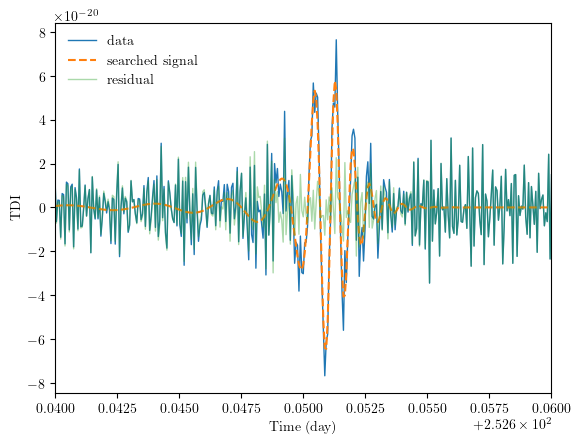

In [ ]:
plt.plot(data_time / DAY, data_slice[0], linewidth=1, label="data")
plt.plot(data_time / DAY, np.sum(np.array(searched_signal_td), axis=0), linestyle="--", label="searched signal")
plt.plot(data_time / DAY, data_slice[0] - np.sum(np.array(searched_signal_td), axis=0), linewidth=1, alpha=0.4, label="residual")
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left", frameon=False)